To begin with, let's first choose an xml parser to import

I decided to go with lxml because it offers the most functionality. 

'pip install lxml'

In [2]:
# loading lxml into our environment
import lxml.etree as ET
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Now, we just need to grab an xml file, specifically a FERC Form 714.

Steps: 
Go to https://ecollection.ferc.gov/
Click on 'Public Submission History'
Filter Form to only show 'Form 714'

In [3]:
# let's load our xml file into our environment. 
# we are focusing on Puge Sound Energy's latest FERC Form 714

'''
xmlFile = 'input_data/ferc_714/puget_sound_energy_ferc_714_4Q2022.xml'

# loading in our xml file
tree = ET.parse(xmlFile)

# accessing the root element of our xml file
root = tree.getroot()

# printing basic info
print('Root Element: ', root.tag)
'''


"\nxmlFile = 'input_data/ferc_714/puget_sound_energy_ferc_714_4Q2022.xml'\n\n# loading in our xml file\ntree = ET.parse(xmlFile)\n\n# accessing the root element of our xml file\nroot = tree.getroot()\n\n# printing basic info\nprint('Root Element: ', root.tag)\n"

In [4]:
# exploring structure
def explore_element(element, level):
    """Prints information about an element and its children."""

    indent = "  " * level
    print(f"{indent}{element.tag}")

    # Get attributes and text content:
    if element.attrib:
        print(f"{indent}Attributes:")
        for key, value in element.attrib.items():
            print(f"{indent}{key} = {value}")
    if element.text:
        print(f"{indent}Text content: {element.text.strip()}")

    # Recursively explore children:
    for child in element:
        explore_element(child, level + 1)

# exploring the structure recursively
# print('Structure:')
# explore_element(root, 0)

In [5]:
# okay finding all elements for forecasting load
# use this as standard... PlanningAreaHourlyDemandAndForecastSummerForecast
target_element = "{http://ferc.gov/form/2022-01-01/ferc}RespondentLegalName"


def extract_entity_name(element_tar, xml_file):

    # loading in our xml file
    tree = ET.parse(xml_file)

    # accessing the root element of our xml file
    root = tree.getroot()

    # Find all instances of the target element:
    target_elements = root.findall(element_tar)

    # Process each element:
    for element in target_elements:
        id = element.attrib.get("id")
        contextRef = element.attrib.get("contextRef")
        decimals = element.attrib.get("decimals")
        unitRef = element.attrib.get("unitRef")
        text_content = element.text.strip()

        # Do something with the extracted information:
        # print(f"ID: {id}")
        #print(f"ContextRef: {contextRef}")
        # print(f"Decimals: {decimals}")
        # print(f"UnitRef: {unitRef}")
        print(f"Text content: {text_content}\n")

    return text_content

ercot_name = extract_entity_name(element_tar=target_element, xml_file='input_data/ferc_714/ercot_ferc_714_4Q2022.xml')
print(ercot_name)

    

Text content: ERCOT

ERCOT


Okay, let's now set up function that pull in the data that we want to grab

we will need functions that grab the following elements

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad

and we really only want the text content which holds the values of the years
and also holds the values of the forecastes net demand

In [6]:
def extract_load_forecast(xml_file):
    '''
    Purpose is to iterate through an xml file and grab load forecast data by 
    utility xml file.
    '''

    # loading in our xml file
    tree = ET.parse(xml_file)

    # accessing the root element of our xml file
    root = tree.getroot()

    # base string we will be using to located elements
    root_el = "{http://ferc.gov/form/2022-01-01/ferc}"

    # root_el length
    root_el_length = len(root_el)

    # these are the elements we will be focusing on
    elements_list=["PlanningAreaHourlyDemandAndForecastYear",
                   "PlanningAreaHourlyDemandAndForecastSummerForecast",
                   "PlanningAreaHourlyDemandAndForecastWinterForecast",
                   "PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad"]

    # here we will be storing our modified elements list
    modified_list = []

    # here we will be storing the data we gather from each section
    forecast_year = []
    summer_forecast = []
    winter_forecast = []
    annual_load_forecast = []


    # iterate through each element and add the root element string 
    # one thing to note is that this is probably subject to change
    for element in elements_list:
        '''iterate through list and add the root element'''

        # overriding the element to now include the root element string
        modified_list.append(root_el + element)

    # printing each element so that we can go back and check that the correct
    # aggregation has been made
    ### print(modified_list)
        
    # creating an empty pandas df where we will be aggregating our data
    df = pd.DataFrame()

    # now we will be finding all instances of our target elements
    for mod_el in modified_list:
        '''iterate through updated element string and extratct info'''
        target_elements = root.findall(mod_el)

        # printing which element we are focusing on at the moment
        print(mod_el[root_el_length:])

        # now we want to process and grab the relevant info
        for element in target_elements:
            id = element.attrib.get("id")
            contextRef = element.attrib.get("contextRef")
            decimals = element.attrib.get("decimals")
            unitRef = element.attrib.get("unitRef")
            text_content = element.text.strip()
            

            # adding respective data to respective list
            if mod_el[root_el_length:] == "PlanningAreaHourlyDemandAndForecastYear":
                forecast_year.append(text_content)

            elif mod_el[root_el_length:] == "PlanningAreaHourlyDemandAndForecastSummerForecast":
                summer_forecast.append(text_content)

            elif mod_el[root_el_length:] == "PlanningAreaHourlyDemandAndForecastWinterForecast":
                winter_forecast.append(text_content)

            elif mod_el[root_el_length:] == "PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad":
                annual_load_forecast.append(text_content)

    print(forecast_year)
    print(summer_forecast)
    print(winter_forecast)
    print(annual_load_forecast)  

    # here we are adding our new lists as cols to our empty dataframe
    df['forecast_year'] = forecast_year
    df['summer_forecast_mw'] = summer_forecast
    df['winter_forecast_mw'] = winter_forecast
    df['annual_load_forecast_mwh'] = annual_load_forecast

    # resetting index
    df.reset_index()

    # making sure our col values are correctly made into the types we want
    df['summer_forecast_mw'] = df['summer_forecast_mw'].astype(float)
    df['winter_forecast_mw'] = df['winter_forecast_mw'].astype(float)
    df['annual_load_forecast_mwh'] = df['annual_load_forecast_mwh'].astype(float)
    df['forecast_year'] = df['forecast_year'].astype(int)

    # now we also want to add column that tracks entity name
    name_element = "{http://ferc.gov/form/2022-01-01/ferc}RespondentLegalName"
    entity_name = extract_entity_name(name_element, xml_file=xml_file)
    df['entity_name'] = str(entity_name)

    return df


In [11]:
# now let's just simply plot the data we have acquired
def plot_it(df_prior, df_current=None, df_2y_prior=None):

    '''
    Plotting the data we have gathered
    '''

    fig_1 = plt.figure()

    try:
        # prior prior year data
        sns.lineplot(data=df_2y_prior, x='forecast_year', y='summer_forecast_mw', color='darkred', 
                    label='2 Year Prior Summer Forecast', alpha=0.33)
        sns.lineplot(data=df_2y_prior, x='forecast_year', y='winter_forecast_mw', color='darkblue', 
                    label='2 Year Prior Winter Forecast', alpha=0.33)
        
    except Exception as e:
        print('an error ocurred:', e)

    # this is prior year data
    sns.lineplot(data=df_prior, x='forecast_year', y='summer_forecast_mw', color='darkred',
                 label='Prior Year Summer Forecast', alpha=0.66)
    sns.lineplot(data=df_prior, x='forecast_year', y='winter_forecast_mw', color='darkblue',
                 label='Prior Year Winter Forecast', alpha=0.66)

    # this is current year data
    sns.lineplot(data=df_current, x='forecast_year', y='summer_forecast_mw', color='darkred',
                 label='Current Year Summer Forecast', alpha=1)
    sns.lineplot(data=df_current, x='forecast_year', y='winter_forecast_mw', color='darkblue',
                 label='Current Year Winter Forecast', alpha=1)        
    
    plt.title(df_prior['entity_name'][0])


    fig_2 = plt.figure()

    try:
        sns.lineplot(data=df_2y_prior, x='forecast_year', y='annual_load_forecast', color='darkgreen', 
                    label='2 Year Prior Annual Load Forecast', alpha=0.33)
        
    except Exception as e:
        print('another error ocurred:', e)
    
    sns.lineplot(data=df_prior, x='forecast_year', y='annual_load_forecast_mwh', color='darkgreen',
                 label='Prior Year Annual Load Forecast', alpha=0.66)
    sns.lineplot(data=df_current, x='forecast_year', y='annual_load_forecast_mwh', color='green', 
                 label='Current Year Annual Load Forecast', alpha=1)
    
    plt.title(df_prior['entity_name'][0])
    
    plt.legend()

    plt.show()


PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032']
['82307.7938080244', '84325.4419457592', '85740.4858653184', '87131.4537065439', '88518.1954535746', '89089.8295538841', '89623.8407080317', '90298.3426404315', '90986.3372724689', '91645.9259995343']
['69318.6352103144', '71474.4120012206', '73190.0378183593', '74900.2573974997', '75842.6342970441', '76633.910457015', '77396.737969818', '78117.1876933941', '78794.1600811384', '79715.1530747536']
['445388328.746044', '464983035.112115', '480009069.154244', '494259921.872217', '508344489.505937', '516425158.971255', '521236672.756719', '527020022.949719', '532397851.349372', '538741674.001326']
Text content: ERCOT

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast

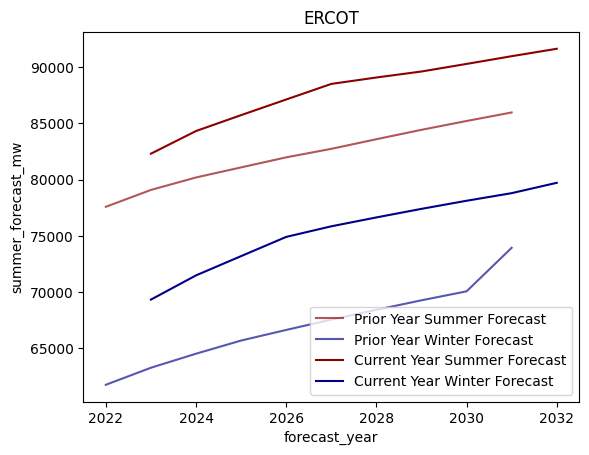

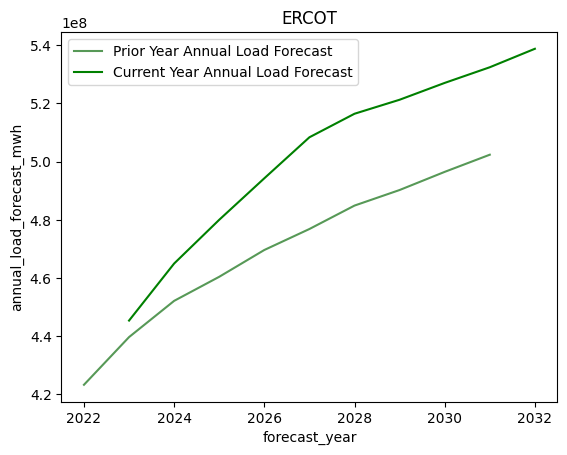

In [12]:
# focusing on ercot
ercot_22_path = 'input_data/ferc_714/ercot_ferc_714_4Q2022.xml'
ercot_21_path = 'input_data/ferc_714/ercot_ferc_714_4Q2021.xml'

df_ercot_22 = extract_load_forecast(xml_file=ercot_22_path)
df_ercot_21 = extract_load_forecast(xml_file=ercot_21_path)

plot_it(df_prior=df_ercot_21, df_current=df_ercot_22)

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032']
['46829', '47475', '47987', '48487', '49150', '49828', '50506', '51292', '52256', '53066']
['33561', '34108', '34585', '35077', '35649', '36253', '36952', '37570', '38389', '39158']
['217534953', '219828483', '222151792', '224652164', '227747499', '231163630', '235069132', '239309574', '244382901', '249554628']
Text content: California Independent System Operator Corporation

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032']
['46319', '46727', '47325', '47749'

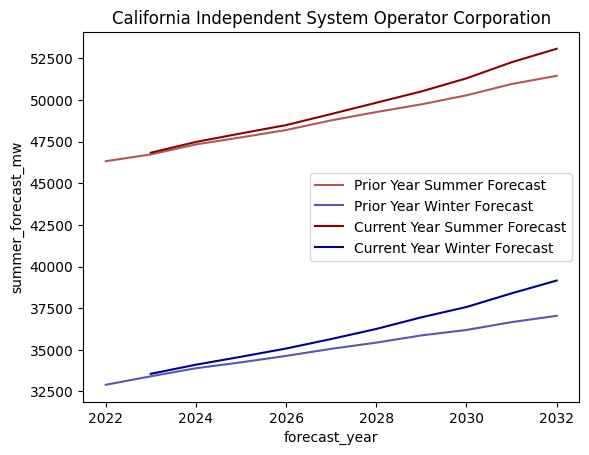

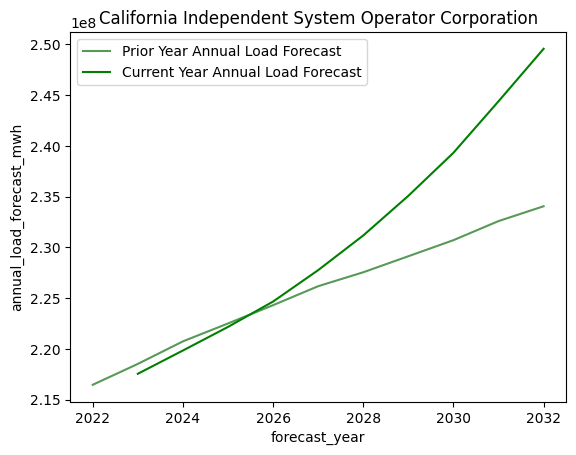

In [13]:
# focusing on caiso
caiso_22_path = 'input_data/ferc_714/caiso_ferc_714_4Q2022.xml'
caiso_21_path = 'input_data/ferc_714/caiso_ferc_714_4Q2021.xml'

df_caiso_22 = extract_load_forecast(xml_file=caiso_22_path)
df_caiso_21 = extract_load_forecast(xml_file=caiso_21_path)

plot_it(df_prior=df_caiso_21, df_current=df_caiso_22)

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032']
['32048', '32280', '32390', '32440', '32410', '32310', '32300', '32490', '32750', '33110']
['24220', '24530', '25100', '25700', '26300', '26990', '27920', '28970', '30160', '31530']
['151780000', '152140000', '152390000', '153250000', '153780000', '154390000', '155530000', '157660000', '160100000', '163260000']
Text content: New York Independent System Operator - Regulatory Affairs

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031']
['31765', '32018', '31778', '31505',

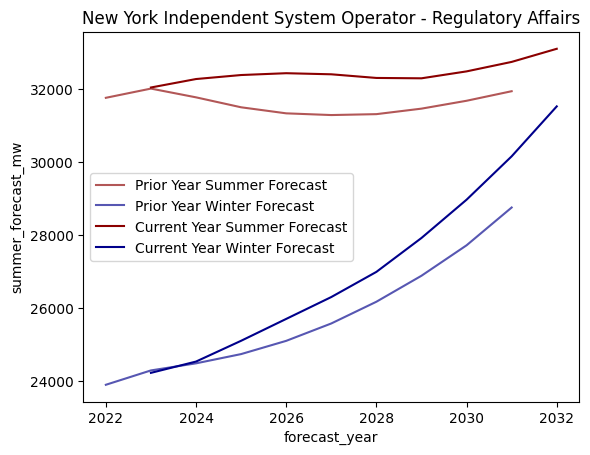

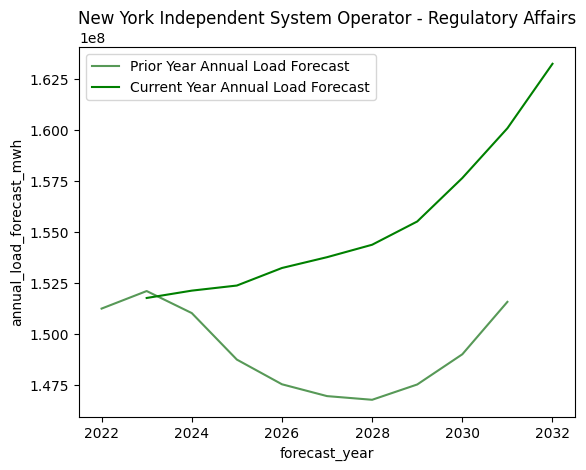

In [14]:
# focusing on nyiso
nyiso_22_path = 'input_data/ferc_714/nyiso_ferc_714_4Q2022.xml'
nyiso_21_path = 'input_data/ferc_714/nyiso_ferc_714_4Q2021.xml'
nyiso_20_path ='input_data/ferc_714/nyiso_ferc_714_4Q2020.xml'

df_nyiso_22 = extract_load_forecast(xml_file=nyiso_22_path)
df_nyiso_21 = extract_load_forecast(xml_file=nyiso_21_path)
# df_nyiso_20 = extract_load_forecast(xml_file=nyiso_20_path)

plot_it(df_prior=df_nyiso_21, df_current=df_nyiso_22)

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033']
['149059', '149737', '150924', '152736', '154275', '155703', '156923', '157899', '158942', '159917', '160971']
['130811', '132667', '133274', '135094', '136812', '139262', '139907', '141280', '142553', '144378', '144992']
['788050000', '801937000', '810251000', '826511000', '841514000', '858269000', '867836000', '878461000', '889393000', '903403000', '909622000']
Text content: PJM Interconnection, LLC

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2022', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2023', '2024']
['148938

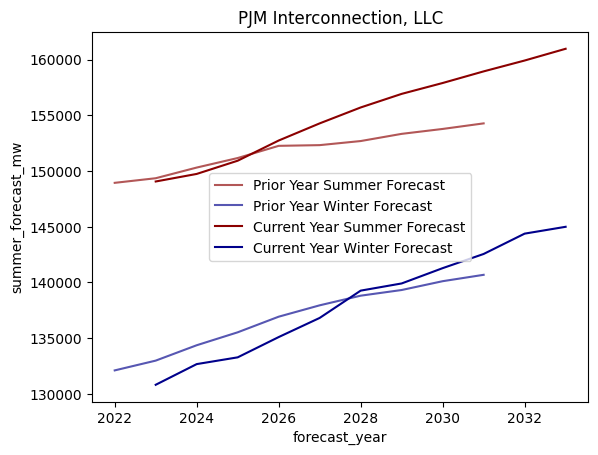

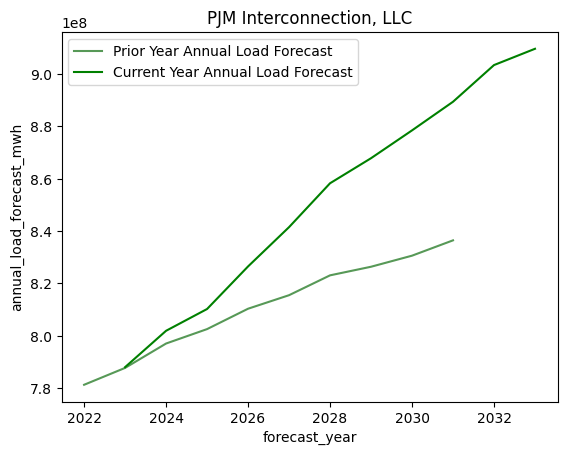

In [15]:
# focusing on caiso
pjm_22_path = 'input_data/ferc_714/pjm_ferc_714_4Q2022.xml'
pjm_21_path = 'input_data/ferc_714/pjm_ferc_714_4Q2021.xml'

df_pjm_22 = extract_load_forecast(xml_file=pjm_22_path)
df_pjm_21 = extract_load_forecast(xml_file=pjm_21_path)

plot_it(df_prior=df_pjm_21, df_current=df_pjm_22)

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032']
['54733', '55996', '57040', '58057', '58979', '59282', '59487', '60563', '60893', '61168']
['47433', '45271', '46997', '47922', '48417', '48647', '49703', '49994', '50274', '50443']
['288308', '299258', '307650', '314323', '320542', '323570', '326197', '332346', '334170', '336422']
Text content: Southwest Power Pool

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031']
['53808', '54616', '54820', '55218', '55855', '56084', '56325', '56579', '57558', '57798']
['43504', '4

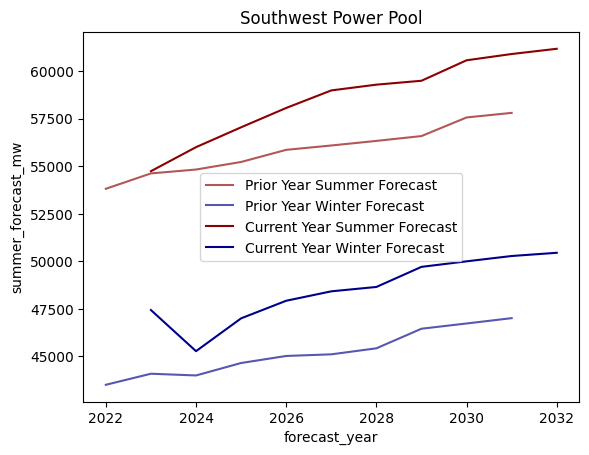

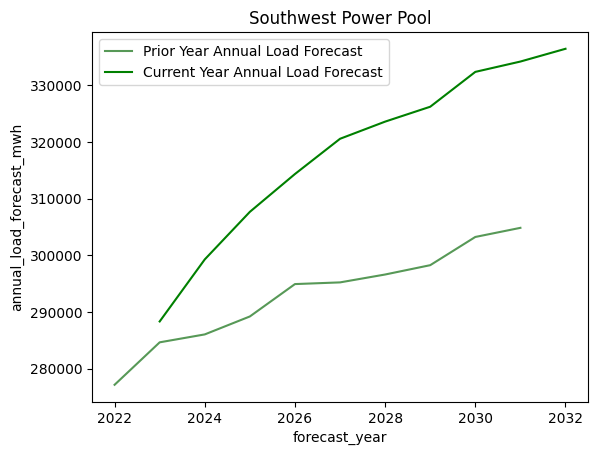

In [16]:
# focusing on spp
spp_22_path = 'input_data/ferc_714/spp_ferc_714_4Q2022.xml'
spp_21_path = 'input_data/ferc_714/spp_ferc_714_4Q2021.xml'

df_spp_22 = extract_load_forecast(xml_file=spp_22_path)
df_spp_21 = extract_load_forecast(xml_file=spp_21_path)

plot_it(df_prior=df_spp_21, df_current=df_spp_22)

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032']
['131509.5', '129546.5', '130411.8', '131054.7', '131679.9', '132519.7', '133044.4', '133536.4', '134129.5', '134629.7']
['106520', '110506', '106659.9', '109750.3', '110382.7', '111326', '111813.8', '112300.4', '112858.3', '113510.5']
['670740400', '676685700', '676059067', '684556117', '688646783', '693766300', '696776867', '699237850', '702157750', '705539033']
Text content: MISO

PlanningAreaHourlyDemandAndForecastYear
PlanningAreaHourlyDemandAndForecastSummerForecast
PlanningAreaHourlyDemandAndForecastWinterForecast
PlanningAreaHourlyDemandAndForecastForecastOfAnnualNetEnergyForLoad
['2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031']
['129032.3', '130001.6', '131187.8'

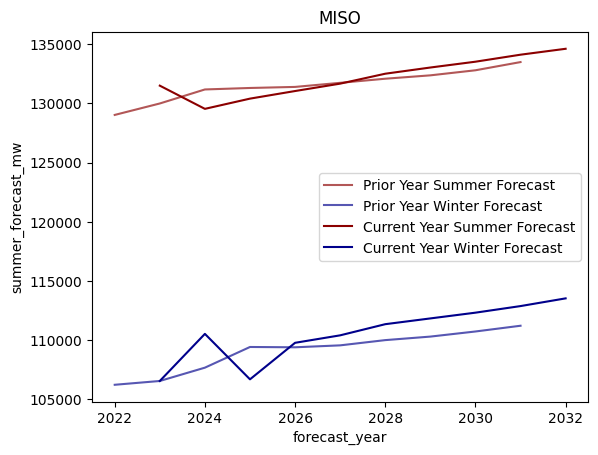

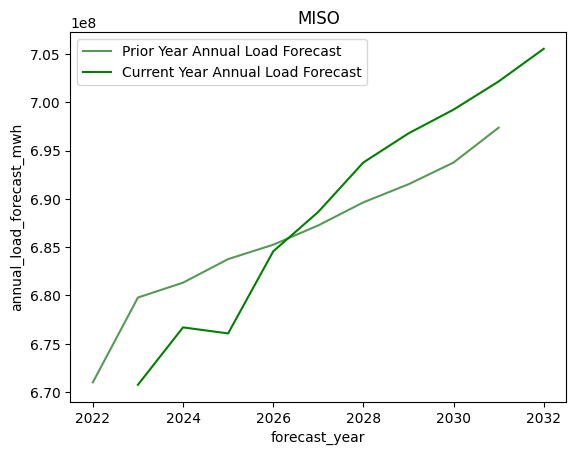

In [17]:
# focusing on miso
miso_22_path = 'input_data/ferc_714/miso_ferc_714_4Q2022.xml'
miso_21_path = 'input_data/ferc_714/miso_ferc_714_4Q2021.xml'

df_miso_22 = extract_load_forecast(xml_file=miso_22_path)
df_miso_21 = extract_load_forecast(xml_file=miso_21_path)

plot_it(df_prior=df_miso_21, df_current=df_miso_22)

